In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import gamma as gammadist
from scipy.stats import norm
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
import GPflow as gpf
import tensorflow as tf

%matplotlib notebook

<IPython.core.display.Javascript object>


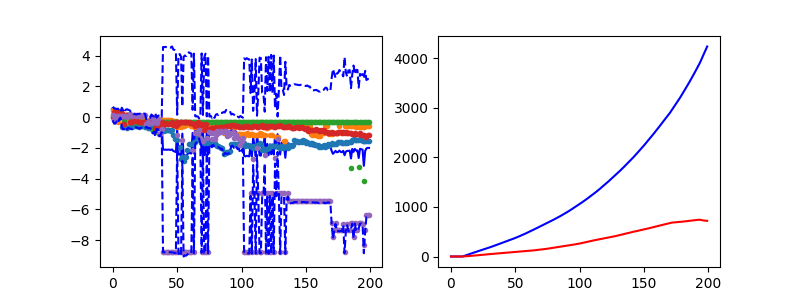

In [3]:
fpath = '/home/mark/Desktop/tmp/2dset'
fnames = [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(38)) ]
def getRMV(fpath,fnames,N):
    R = np.empty([N,len(fnames)])
    T = np.zeros([N,2])
    X = np.array(range(N)).astype(float)
    n = len(fnames)
    for j in range(n):    
        f = os.path.join(fpath,fnames[j])
        #print(f)
        names = (open(f).readline().strip('\n')+''.join([',q{}'.format(i) for i in range(5)])).replace(' ','')
        df = pd.read_csv(f,names=names.split(','),skiprows=1,engine='c')
        tv = np.array(df['taq'].values)
        data =df['trueyatxrecc'].values
        mn = min([i for i in data if i>0])
        data2 = np.maximum(mn,data)
        R[:,j] = np.log10(data2) #should properly handle edge
        
        T[:,0] += np.cumsum(tv)
        T[:,1] += np.cumsum(tv)**2
        #print(np.max(np.cumsum(tv)))
        #print(np.max(T))
        #print(T[-1,0],fnames[j])
    #print(R)
    M = np.mean(R,axis=1)
    V = np.var(R,axis=1)
    return X,R,M,V,T,n
f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,3])
X,R,M,V,Traw,n = getRMV(fpath,fnames,200)
a[0].plot(X,M,'b')
a[0].plot(X,R,'.')
a[0].plot(X,M+2*np.sqrt(V),'b--')
a[0].plot(X,M-2*np.sqrt(V),'b--')
a[1].plot(X,Traw[:,0]/n,'b')
a[1].plot(X,np.sqrt(Traw[:,1]/n-(Traw[:,0]/n)**2),'r')

z = np.linspace(0,220,200)
#print(V)

<IPython.core.display.Javascript object>


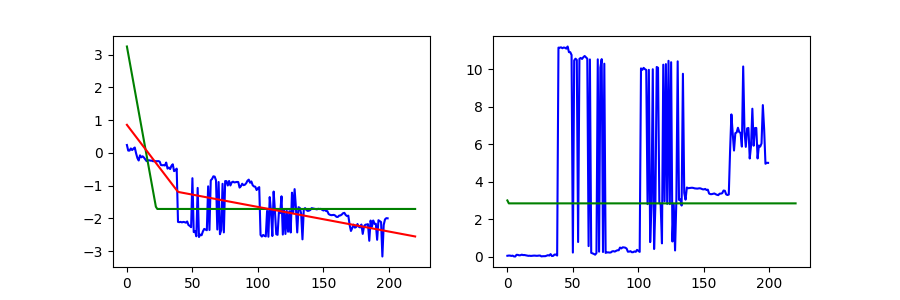

In [4]:
def fitXV(X,M):

    a0=1.
    sigma0=1
    b0=0.1
    c0=1
    def llk(para):
        a = abs(para[0]) # true distribution is a truncated normal in true value?
        b = abs(para[1])
        c = para[2]
        sigma = abs(para[3])
        pa = gammadist.logpdf(a,4.,scale=1.)
        pa+= gammadist.logpdf(b,4.,scale=0.1)
        pa+= norm.logpdf(c,loc=-3.,scale=2)
        pa+= gammadist.logpdf(sigma,1.,scale=1.)
        
        Yh = np.maximum(c*np.ones_like(X),a-b*X)
        E = M-Yh
        return np.sum(((E)**2)/sigma**2)-pa
    res = minimize(llk,[a0,b0,c0,sigma0],method='Nelder-Mead')
    return [abs(res.x[0]),abs(res.x[1]),res.x[2],abs(res.x[3])]
def model(x,theta):
        return np.maximum(theta[0]-theta[1]*x,theta[2]-theta[3]*x)

def fit2line(X,M):
    
    m0 = -min(-1e-9,(M[20]-M[0])/(X[20]-X[0]))
    #m1 = -min(-1e-9,(M[-1]-M[-21])/(X[-1]-X[-21]))
    a0 = M[0]+m0*X[0]
    #a1 = M[-1]+m1*X[-1]
    theta0  = [a0,m0,M[-1],1e-6,1.]
    
    def llk(theta):
        pa = norm.logpdf(theta[0],loc=0.,scale=1.)
        #print(pa,theta[1],gammadist.logpdf(theta[1],4.,scale=1.))
        pa += gammadist.logpdf(theta[1],4.,scale=0.1)
        
        pa += norm.logpdf(theta[2],loc=0.,scale=1.)
        
        pa += gammadist.logpdf(theta[3],4.,scale=0.1)
        pa += gammadist.logpdf(theta[4],2.,scale=0.1)
        Yh = model(X,theta)
        E = M-Yh
        L = np.sum(((E)**2)/theta[4]**2)-pa
        
        return L
    res = minimize(llk,theta0,method='Nelder-Mead')

    return res.x

f,a=plt.subplots(nrows=1,ncols=2,figsize=[9,3])
a[0].plot(X,M,'b')
a[1].plot(X,V,'b')
aV,bV,cV,sigmaV= fitXV(X[10:],V[10:])
aM,bM,cM,sigmaV= fitXV(X[10:],M[10:])
thetaM = fit2line(X[10:],M[10:])

#alphaV,gammaV,sigmaV,betaV = [15,0.6,1e-3,1e-6]
Vz = np.maximum(cV*np.ones_like(z),aV-bV*z)
Mz = np.maximum(cM*np.ones_like(z),aM-bM*z)
M2 = model(z,thetaM)
a[1].plot(z,Vz,'g')
a[0].plot(z,Mz,'g')
a[0].plot(z,M2,'r')

<IPython.core.display.Javascript object>


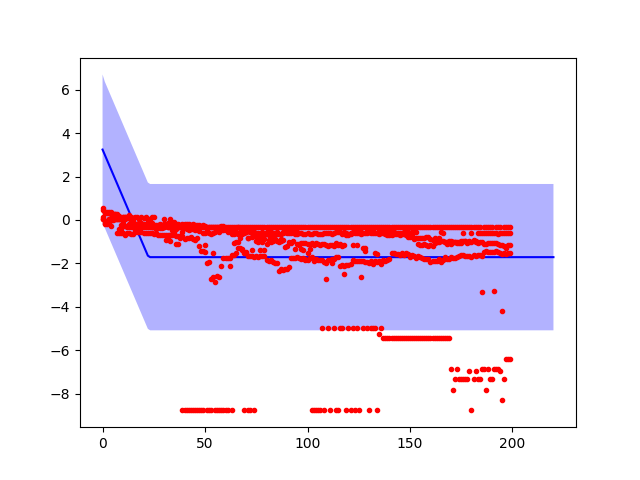

In [5]:
plt.figure()
plt.plot(z,Mz,'b')
plt.fill_between(z,Mz-2*np.sqrt(Vz),Mz+2*np.sqrt(Vz),edgecolor=None,facecolor='b',alpha=0.3)
plt.plot(X,R,'r.')

In [7]:
def getpara(j):
    fpath = '/home/mark/Desktop/tmp/2dset'
    fnames = [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(j)) ]
    batch,number,dim,ls,noise,tail = fnames[0].split('_')
    N = int(tail.strip('.csv')[1:])
    X,R,M,V,Traw,ni= getRMV(fpath,fnames,N)
    
    thetaM = fitXV(X,M)
    theta2M = fit2line(X,M)
    thetaV = fitXV(X,V)
    #print(M)
    
    
    ls = float(ls[1:])/100.
    noise = 10**-(float(noise[1:])/10.)
    return ls,noise,np.hstack([theta2M,thetaV]),Traw,ni,N
_,_,_,_,_,nopt = getpara(0)
ndata = 160
N = np.empty(ndata)
L = np.empty(ndata)
D = np.empty([ndata,9])
Tacc = np.zeros([nopt,2])
nacc = 0
import tqdm
for i in tqdm.tqdm(range(ndata)):
    L[i],N[i],D[i,:],Traw,ni,_ = getpara(i)
    Tacc+=Traw
    #print(Traw)
    nacc+=ni


100%|██████████| 160/160 [02:10<00:00,  1.35it/s]


<IPython.core.display.Javascript object>


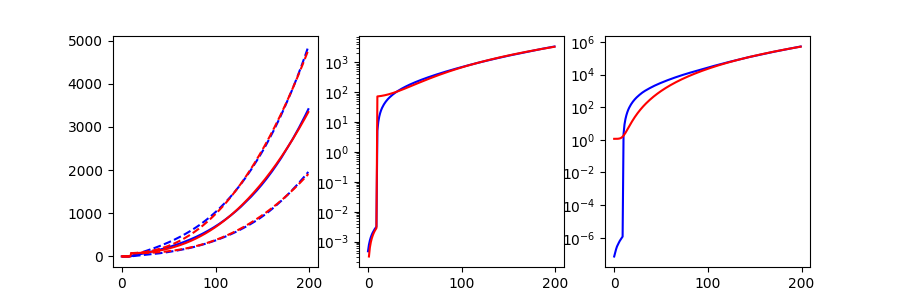

fit model 0.008041708843524979*x^2.4402350111767377 + 70.2441832559456 +N(0,27.673773298008854)
fit model 1.919110610527353e-05*x^4.536716110118223 + 1.1545020369959174 +N(0,196.6894398944976)


/home/mark/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in double_scalars
/home/mark/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in double_scalars
/home/mark/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in double_scalars


In [8]:
Tm = Tacc[:,0]/nacc
Tv = Tacc[:,1]/nacc - (Tacc[:,0]/nacc)**2
f,a = plt.subplots(nrows=1,ncols=3,figsize=[9,3])
a[0].plot(X,Tm,'b')
a[0].plot(X,Tm+2*np.sqrt(Tv),'b--')
a[0].plot(X,Tm-2*np.sqrt(Tv),'b--')
a[1].plot(X,Tm,'b')
a[2].plot(X,Tv,'b')
def llk(X,Y,theta,pr_alpha, pr_beta):
    X=list(X)
    Y=list(Y)
    N=len(X)
    a,b,c,s = theta
    accf=-N*np.log(s)
    accD = np.array([0.,0.,0.,-N/s])
    for i in range(4):
        accf+= (pr_alpha[i]-1.)*np.log(theta[i])-theta[i]*pr_beta[i]
        accD[i] += (pr_alpha[i]-1.)/theta[i] - pr_beta[i]
    for i in range(N):
        error = (a*X[i]**b+c-Y[i])/(s**2)
        accD[0] -= error*(X[i]**b)
        accD[1] -= error*(a*np.log(X[i])*X[i]**b)
        accD[2] -= error
        accD[3] += (error**2)*s
        accf -= (0.5*error**2)*s**2
    #print theta,accf
    return accf,accD


def overheadregression(X,Y):
    #print(X,Y)
    pr_alpha = [4.,8.,10.,2.]
    pr_beta = [2.,4.,1,0.5]
    def f(x):
        l,g =llk(X,Y,x,pr_alpha,pr_beta)
        #print x,-l
        return -l,-g

    res = minimize(f,[1.,2.,1.,1.],method='L-BFGS-B',jac=True,bounds=((1e-6,None),(1.,None),(1e-6,None),(1e-6,None)))#,bounds=((0.,1e3),(0.,1e3),(0.,1e3),(0.,1e3)))
    para = np.abs(res.x)
    print( 'fit model {}*x^{} + {} +N(0,{})'.format(*para))
    return para
para = overheadregression(X[10:],Tm[10:])
oapprox = lambda x:(x>=10)*(para[0]*x**para[1]+para[2])+(x*Tm[9]/10.)*(x<10)
vpara = overheadregression(X[10:],Tv[10:])
vapprox = lambda x:vpara[0]*x**vpara[1]+vpara[2]
Test = oapprox(X)

a[0].plot(X,np.array(oapprox(X)),'r')
a[0].plot(X,np.array(oapprox(X)+2*np.sqrt(vapprox(X))),'r--')
a[0].plot(X,np.array(oapprox(X)-2*np.sqrt(vapprox(X))),'r--')
a[1].semilogy(X,np.array(oapprox(X)),'r')
a[2].semilogy(X,np.array(vapprox(X)),'r')

<IPython.core.display.Javascript object>


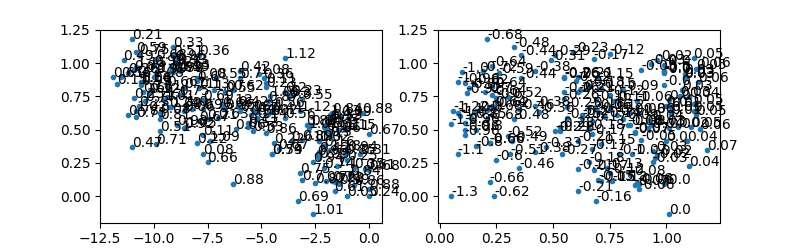

<IPython.core.display.Javascript object>


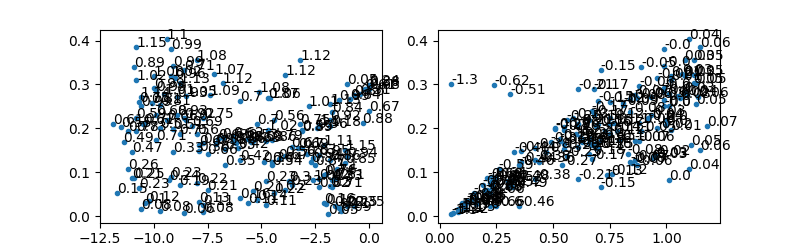

<IPython.core.display.Javascript object>


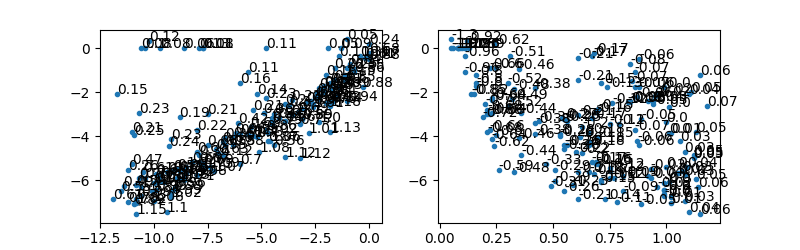

<IPython.core.display.Javascript object>


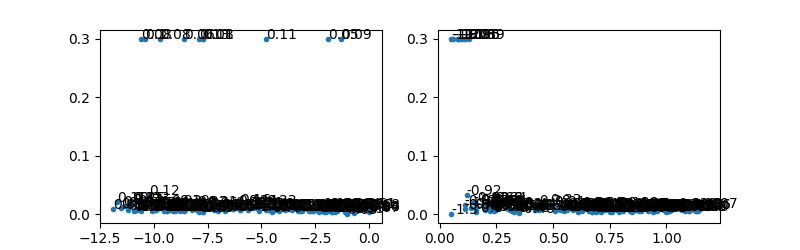

<IPython.core.display.Javascript object>


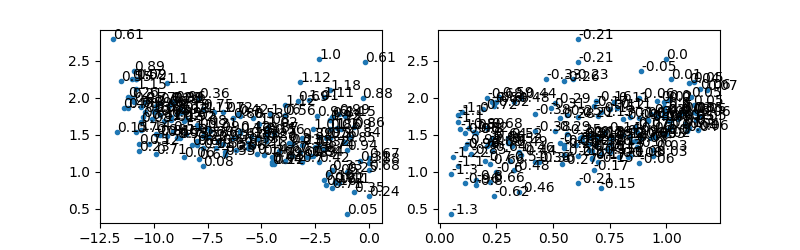

<IPython.core.display.Javascript object>


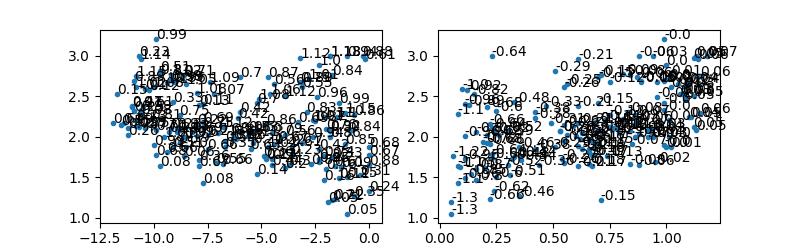

<IPython.core.display.Javascript object>


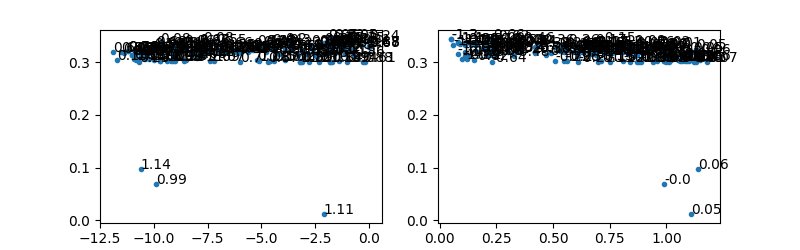

<IPython.core.display.Javascript object>


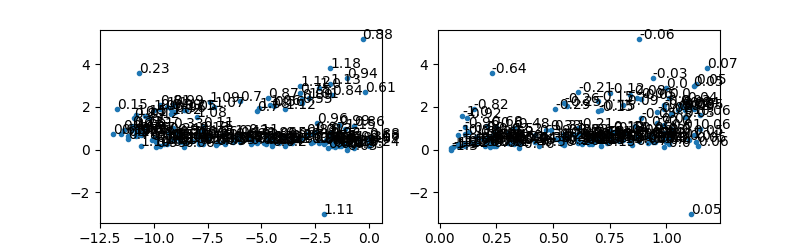

<IPython.core.display.Javascript object>


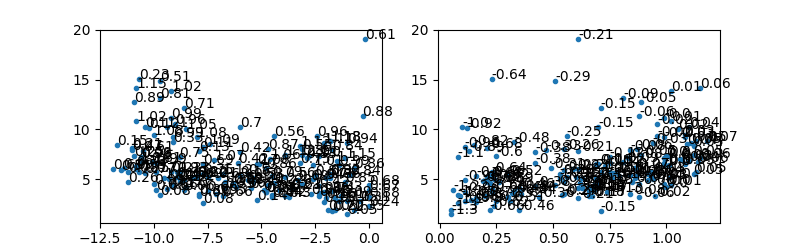

In [9]:
for j in range(9):
    f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,2.5])
    a[0].plot(np.log10(N),D[:,j],'.')
    a[1].plot(L,D[:,j],'.')
    for i in range(N.size):
        a[0].text(np.log10(N)[i],D[i,j],str(L[i]))
        a[1].text(L[i],D[i,j],str(np.round(np.log10(L[i]),2)))

In [10]:
import GPflow as gpf
m=N.size

mtrain=int(0.8*m)
mtest = m-mtrain

def fitgp(X,Y,Xt,Yt):
    kr = gpf.kernels.RBF(2,ARD=True)+gpf.kernels.Constant(1)
    g = gpf.gpr.GPR(X,Y,kr)
    g.optimize()
    print(g)
    m,v= g.predict_y(Xt)
    e = m-Yt
    re = e/np.sqrt(v)
    #print(Y-np.mean(Y))
    std = np.sqrt(sum((Y-np.mean(Y))**2)/float(mtrain))[0]
    rms = np.sqrt(sum(e**2)/float(mtest))[0]
    print(std,rms,std/rms)
    return g
X_tr = np.vstack([L[:mtrain],np.log10(N[:mtrain])]).T
X_te = np.vstack([L[mtrain:],np.log10(N[mtrain:])]).T
g = [None for i in range(9)]
for j in range(9):
    print('{}-------------------'.format(j))
    g[j] = fitgp(X_tr,D[:mtrain,j].reshape([mtrain,1]),X_te,D[mtrain:,j].reshape([mtest,1]))

0-------------------
name.kern.rbf.variance transform:+ve prior:None
[ 0.45459734]
name.kern.rbf.lengthscales transform:+ve prior:None
[  2.41891384e+04   1.46514350e+01]
name.kern.constant.variance transform:+ve prior:None
[  1.00000000e-06]
name.likelihood.variance transform:+ve prior:None
[ 0.04584999]

0.292944810052 0.183183120887 1.59919106429
1-------------------
name.likelihood.variance transform:+ve prior:None
[ 0.00215115]
name.kern.constant.variance transform:+ve prior:None
[ 0.04365604]
name.kern.rbf.lengthscales transform:+ve prior:None
[ 1.62636864  3.04836053]
name.kern.rbf.variance transform:+ve prior:None
[ 0.06600307]

0.0982702180882 0.0489162937885 2.00894651817
2-------------------
name.kern.rbf.variance transform:+ve prior:None
[ 28.24148662]
name.kern.rbf.lengthscales transform:+ve prior:None
[  0.36039607  14.36445211]
name.kern.constant.variance transform:+ve prior:None
[  4.81405962e-06]
name.likelihood.variance transform:+ve prior:None
[ 0.25773127]

2.134115

In [11]:
lep = np.linspace(0.05,1.2,50)
nop = np.linspace(-12,0.,50)
stops = [int(nopt*i) for i in [0.,0.1,0.2,0.3,0.5,1.]]
A=[np.empty([50,50]) for i in stops]
B=[np.empty([50,50]) for i in stops]
def predict(l,n,s):
    p = [q.predict_f(np.array([l,n]).reshape([1,2]))[0][0,0] for q in g]
    m = lambda x :model(x,p[:4])
    v = lambda x :np.maximum(p[7],p[5]-p[6]*x)+p[4]
    return m(s),v(s)
for i,l in enumerate(lep):
    for j,n in enumerate(nop):
        mu,var = predict(l,n,np.array(stops))
        for k,s in enumerate(stops):
            A[k][j,i] = mu[k]
            B[k][j,i] = np.sqrt(var[k])
            

0


<IPython.core.display.Javascript object>


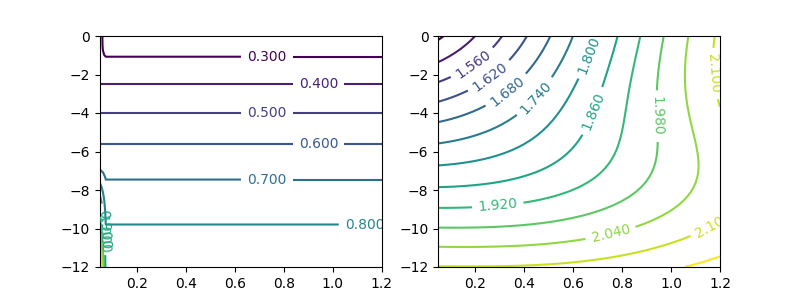

20


<IPython.core.display.Javascript object>


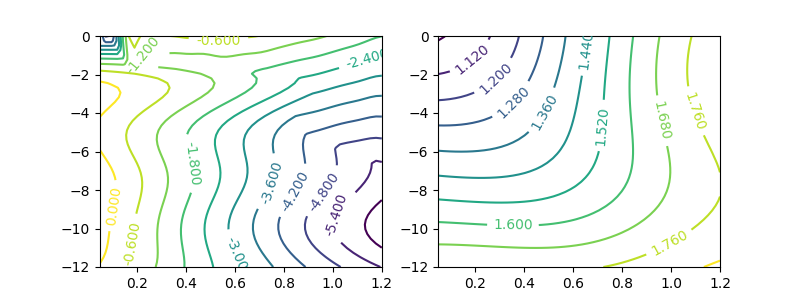

40


<IPython.core.display.Javascript object>


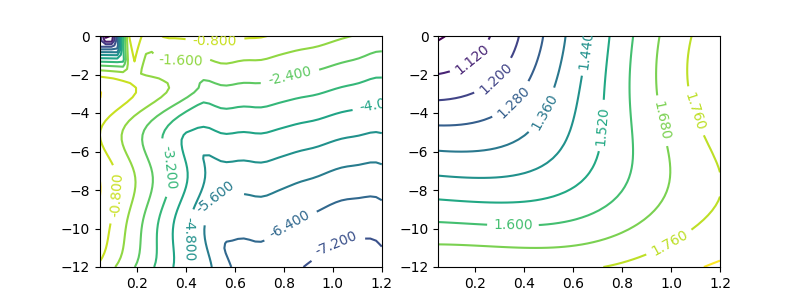

60


<IPython.core.display.Javascript object>


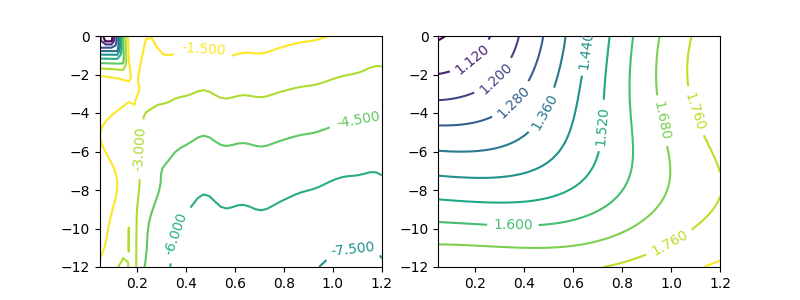

100


<IPython.core.display.Javascript object>


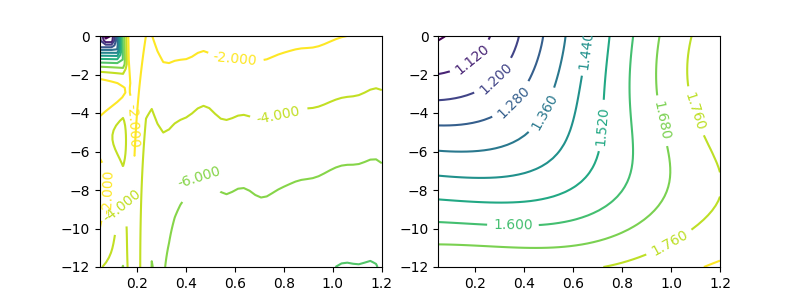

200


<IPython.core.display.Javascript object>


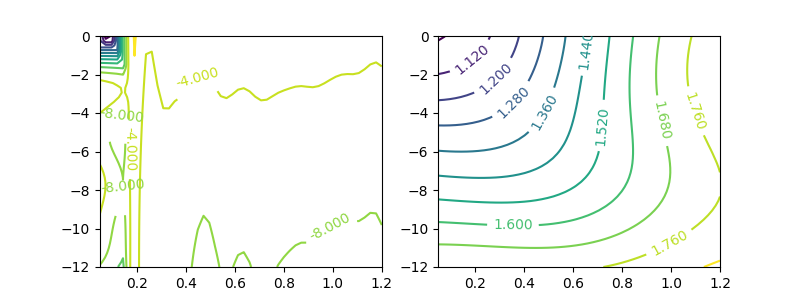

In [12]:
for i in range(len(A)):
    print(stops[i])
    f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,3])
    cs = a[0].contour(lep,nop,A[i],12)
    a[0].clabel(cs, inline=1, fontsize=10)
    cs = a[1].contour(lep,nop,B[i],12)
    a[1].clabel(cs, inline=1, fontsize=10)


/home/mark/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


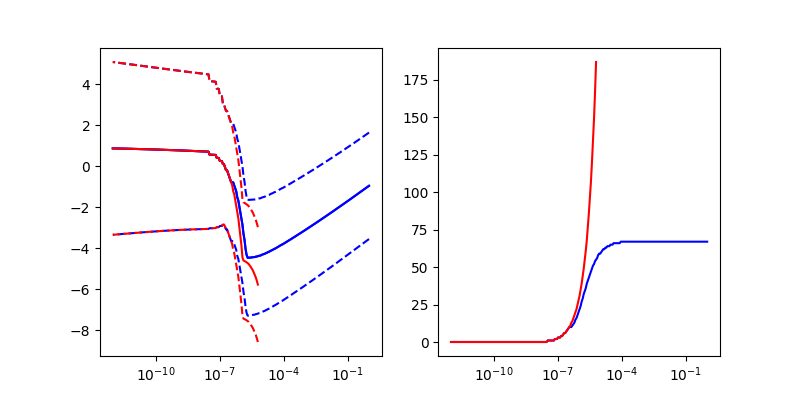

In [25]:
Lt=0.5
def predictatfixedcost(var,l,B,over=True):
    stepcost = 10*1e-6/var
    predictcost = (np.array(range(200))+1)*stepcost + Test*over
    steps=np.argmax(predictcost>B) if predictcost[-1]>B else 100
    m,v = predict(l,np.log10(var),steps)
    return m,v,steps
s = np.logspace(0,-12,250)
mp = np.empty_like(s)
vp = np.empty_like(s)
sp = np.empty_like(s)
for i,v in enumerate(s):
    mp[i],vp[i],sp[i] = predictatfixedcost(v,Lt,300)
mx = np.empty_like(s)
vx = np.empty_like(s)
sx = np.empty_like(s)
for i,v in enumerate(s):
    mx[i],vx[i],sx[i] = predictatfixedcost(v,Lt,300,over=False)
    if sx[i]==100:
        mx[i]=np.inf
        sx[i]=np.inf
f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,4])
a[0].semilogx(s,mp,'b')
a[0].semilogx(s,mp+2*np.sqrt(vp),'b--')
a[0].semilogx(s,mp-2*np.sqrt(vp),'b--')
a[0].semilogx(s,mp,'b')
a[1].semilogx(s,sp,'b')
a[0].plot(s,mx,'r')
a[0].semilogx(s,mx+2*np.sqrt(vx),'r--')
a[0].semilogx(s,mx-2*np.sqrt(vx),'r--')
a[1].semilogx(s,sx,'r')

In [27]:
def gettest(j,L):
    fpath = '/home/mark/Desktop/tmp/2dtest'
    fnames=[]
    for f in [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(j)) ]:
        batch,number,dim,ls,noise,tail = f.split('_')
        #print(ls)
        if int(ls[1:])/100.==L:
            fnames.append(f)
    N = int(tail.strip('.csv')[1:])
    
    X,R,M,V,Traw,ni= getRMV(fpath,fnames,N)
    
    ls = float(ls[1:])/100.
    noise = 10**-(float(noise[1:])/10.)
    return M,V,noise
nt=30
N = np.empty(nt)
M = np.empty([nopt,nt])
V = np.empty([nopt,nt])
for i in tqdm.tqdm(range(nt)):
    M[:,i],V[:,i],N[i] = gettest(i,Lt)

100%|██████████| 30/30 [00:01<00:00, 25.14it/s]


/home/mark/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


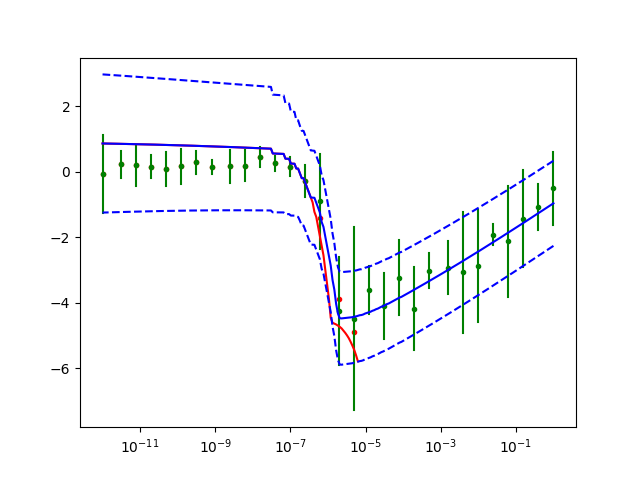

In [28]:
plt.figure()
for i in range(30):    
    nstepsx = sx[np.argmax(N[i]>=s)]
    if not np.isinf(nstepsx):
        mean = M[int(nstepsx),i]
        plt.semilogx(N[i],mean,'r.')
    nstepsp = sp[np.argmax(N[i]>=s)]
    if not np.isinf(nstepsp):
        mean = M[int(nstepsp),i]
        plt.plot(N[i],mean,'g.')
        plt.plot([N[i],N[i]],[mean-2*np.sqrt(V[int(nstepsp),i]),mean+2*np.sqrt(V[int(nstepsp),i])],'g')
plt.plot(s,mx,'r')
plt.plot(s,mp,'b')
plt.plot(s,mp+np.sqrt(vp),'b--')
plt.plot(s,mp-np.sqrt(vp),'b--')

In [49]:
a = np.linspace(-4,5,12)
print(a)
b = (a*(a>0))
print(b)

[-4.         -3.18181818 -2.36363636 -1.54545455 -0.72727273  0.09090909
  0.90909091  1.72727273  2.54545455  3.36363636  4.18181818  5.        ]
[-0.         -0.         -0.         -0.         -0.          0.09090909
  0.90909091  1.72727273  2.54545455  3.36363636  4.18181818  5.        ]
